# Deep learning Flow

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 변하지 않는 Deep learning Flow 

<img src=../../statics/imgs/dl_flow.png> </img>

## 1. Data 가져오기

TensorFlow에서 제공하는 MNIST 예제

- 데이터 shape, dtype 확인하기

In [3]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

In [4]:
print(train_x.shape)
print(test_x.shape)

(60000, 28, 28)
(10000, 28, 28)


In [5]:
print(train_y.shape)
print(test_y.shape)

(60000,)
(10000,)


In [6]:
print(train_x.dtype)
print(test_x.dtype)

print(train_y.dtype)
print(test_y.dtype)

uint8
uint8
uint8
uint8


데이터 하나 확인하기

In [7]:
image = train_x[77]
image.shape

(28, 28)

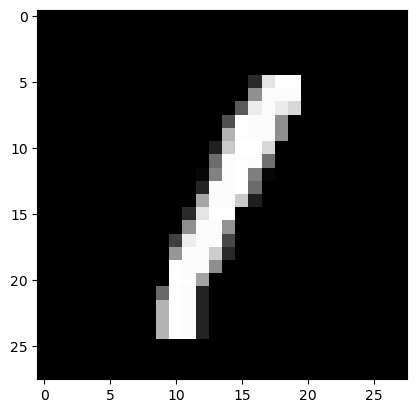

In [8]:
plt.imshow(image, 'gray')
plt.show()

#### 데이터를 받으면 데이터를 이해하기 위해 노력해야합니다! 


#### ex> 훈련용 데이터셋에는 각 숫자의 그림이 몇개씩 들어가 있나? (QUIZ)

----

In [9]:
y_unique, y_counts = np.unique(train_y, return_counts=True)
print(y_unique, y_counts)

[0 1 2 3 4 5 6 7 8 9] [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


In [16]:
# 데이터프레임화
df_view = pd.DataFrame(data={"count" : y_counts}, index=y_unique)
df_view.sort_values("count", ascending=False)

,count
1,6742
7,6265
3,6131
2,5958
9,5949
0,5923
6,5918
8,5851
4,5842
5,5421


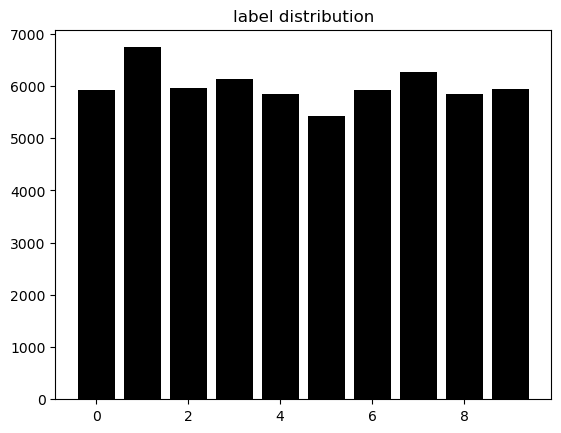

In [12]:
plt.bar(x=y_unique, height=y_counts, color="black")
plt.title("label distribution")
plt.show()

### 막간 퀴즈

다음 코드를 완성하여, 아래 이미지를 시계 반대 방향으로 90도 회전하고 아래위를 반전 시키기

In [13]:
image = tf.constant(image)

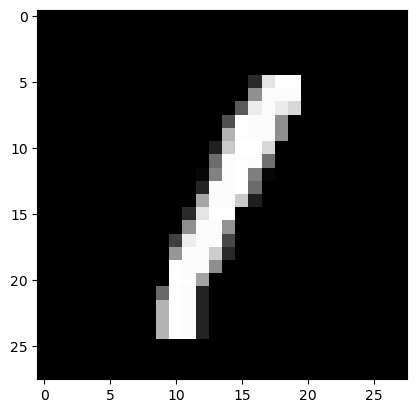

In [14]:
plt.imshow(image, 'gray')
plt.show()

In [15]:
plt.imshow(?????????(image), 'gray')
plt.show()

SyntaxError: invalid syntax (2866030177.py, line 1)

----

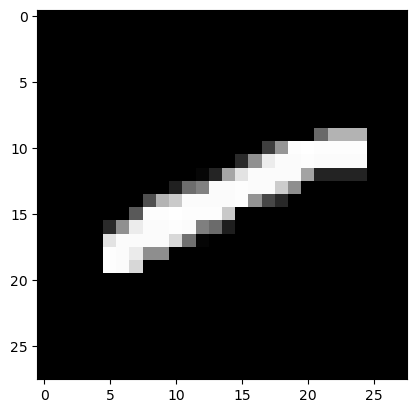

In [15]:
plt.imshow(tf.transpose(image), 'gray')
plt.show()

## 2. Preprocessing

- 데이터 검증 
- 전처리 
- 데이터 증강 ... (이 건 추후에!)

등 많은 작업을 거쳐 모델의 입력값이 될 수 있게끔 변형시켜주는 것

#### 데이터 검증 

 - 데이터 중에 학습에 포함 되면 안되는 것이 있는가? ex> 개인정보가 들어있는 데이터, 테스트용 데이터에 들어있는것, 중복되는 데이터
 - 학습 의도와 다른 데이터가 있는가? ex> 얼굴을 학습하는데 발 사진이 들어가있진 않은지(가끔은 의도하고 일부러 집어넣는 경우도 있음)
 - 라벨이 잘못된 데이터가 있는가? ex> 7인데 1로 라벨링, 고양이 인데 강아지로 라벨링 
 -  ... 등
 

In [17]:
# preprocessing할 때 로직에 대한 실수를 하지 않기 위해
# 함수와 클래스로 구현을 많이 함

def validate_pixel_scale(x):
    return 255 >= x.max() and 0 <= x.min() # 픽셀값이 이상한 데이터는 걸러내는 작업

validated_train_x = np.array([x for x in train_x if validate_pixel_scale(x)])
validated_train_y = np.array([y for x, y in zip(train_x, train_y) if validate_pixel_scale(x)])

print(validated_train_x.shape)
print(validated_train_y.shape)

(60000, 28, 28)
(60000,)


#### 전처리 

 - 입력하기 전에 모델링에 적합하게 처리! 
 - 대표적으로 Scaling, Resizing, label encoding 등이 있다. 
 - dtype, shape 항상 체크!!

##### Scaling

In [18]:
def scale(x):
    return (x / 255.0).astype(np.float32) # 0 ~ 1사이의 값을 갖도록

In [20]:
# 확인
sample = scale(validated_train_x[777])

sample.max(), sample.min() # 직접 확인해보거나

(1.0, 0.0)

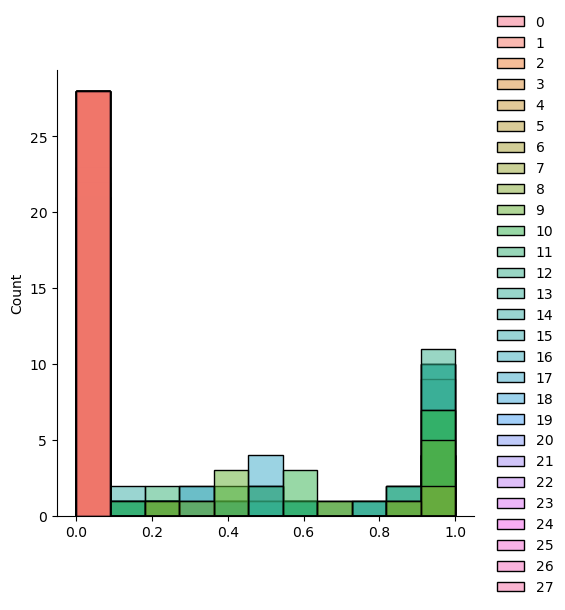

In [21]:
sns.displot(sample) # 시각화

In [22]:
# 실행
scaled_train_x = np.array([scale(x) for x in validated_train_x])

##### Flattening

 - 이번에 사용할 모델은 기본적인 Feed-Forward Neural Network
 - 1차원 벡터가 Input의 샘플 하나가 된다. (2차원 텐서라는 말)

In [23]:
# 실행
flattend_train_x = scaled_train_x.reshape(60000, -1)

# 확인
flattend_train_x.shape

(60000, 784)

##### Label encoding

 - One-Hot encoding
 - `tf.keras.utils.to_categorical` 사용! 

In [24]:
tf.keras.utils.to_categorical(5, num_classes=10)

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [25]:
# 실행
ohe_train_y = np.array([tf.keras.utils.to_categorical(y, num_classes=10) for y in validated_train_y])

# 확인
ohe_train_y.shape

(60000, 10)

### 보통은 큰 작업을 하나의 클래스로 만들어서 관리한다. 


In [26]:
class DataLoader():
    def __init__(self):
        # 데이터 불러오기
        (self.train_x, self.train_y), \
            (self.test_x, self.test_y) = tf.keras.datasets.mnist.load_data()

    def validate_pixel_scale(self, x):

        return 255 >= x.max() and 0 <= x.min()

    def scale(self, x):
        """
        Make pixels within 0 ~ 1

        return 
            scaled image (dtype=float32)
        """
        return (x / 255.0).astype(np.float32)

    def preprocess_dataset(self, dataset):
        """
        feature 
            shape : (num_data, 28, 28)
        target 
            shape : (num_data,)

        return 
            feature 
                shape : (num_data, 28, 28)
            target 
                shape : (num_data,)
        """
        (feature, target) = dataset

        validated_x = np.array(
            [x for x in feature if self.validate_pixel_scale(x)])

        validated_y = np.array([y for x, y in zip(feature, target)
                                if self.validate_pixel_scale(x)])

        # scaling #
        scaled_x = np.array([self.scale(x) for x in validated_x])

        # flattening #
        flattend_x = scaled_x.reshape((scaled_x.shape[0], -1))

        # label encoding #
        ohe_y = np.array([tf.keras.utils.to_categorical(
            y, num_classes=10) for y in validated_y])
        
        return flattend_x, ohe_y

    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))

    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))

In [27]:
# 객체 생성
mnist_loader = DataLoader()

In [28]:
# train 데이터에 대해 실시
train_x, train_y = mnist_loader.get_train_dataset()

In [29]:
print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

(60000, 784) float32
(60000, 10) float32


In [30]:
# test 데이터에 대해 실시
test_x, test_y = mnist_loader.get_test_dataset()

print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(10000, 784) float32
(10000, 10) float32


## 3. Modeling
 1. 모델 정의 
 2. 학습 로직 - 비용함수, 학습파라미터 세팅
 3. 학습


#### 모델 정의

In [31]:
from tensorflow.keras.layers import Dense, Activation

model = tf.keras.Sequential()
# .add를 통해 레이어를 추가할 수 있음
model.add(Dense(15, input_dim = 784))
model.add(Activation('sigmoid'))
model.add(Dense(10)) # output dim에 맞게 설정
model.add(Activation('softmax'))

In [32]:
# 모델 정보 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                11775     
                                                                 
 activation (Activation)     (None, 15)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 11935 (46.62 KB)
Trainable params: 11935 (46.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 학습 로직

In [33]:
learning_rate = 0.03
opt = tf.keras.optimizers.SGD(learning_rate) # 최적화
loss = tf.keras.losses.categorical_crossentropy # loss

In [34]:
# 모델 정의(최적화를 어떻게 하고, loss 함수는 무엇을 할건지, 모델의 성능의 지표는 무엇으로 할건가)
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

#### 학습 실행

In [37]:
# .fit
hist = model.fit(train_x, train_y, epochs = 10, batch_size=256)

Epoch 1/10
235/235 [==============================] - 0s 2ms/step - loss: 0.6040 - accuracy: 0.8650
Epoch 2/10
235/235 [==============================] - 0s 1ms/step - loss: 0.5721 - accuracy: 0.8691
Epoch 3/10
235/235 [==============================] - 0s 1ms/step - loss: 0.5452 - accuracy: 0.8733
Epoch 4/10
235/235 [==============================] - 0s 2ms/step - loss: 0.5221 - accuracy: 0.8768
Epoch 5/10
235/235 [==============================] - 0s 2ms/step - loss: 0.5021 - accuracy: 0.8798
Epoch 6/10
235/235 [==============================] - 0s 1ms/step - loss: 0.4847 - accuracy: 0.8821
Epoch 7/10
235/235 [==============================] - 0s 2ms/step - loss: 0.4694 - accuracy: 0.8854
Epoch 8/10
235/235 [==============================] - 0s 1ms/step - loss: 0.4558 - accuracy: 0.8877
Epoch 9/10
235/235 [==============================] - 0s 1ms/step - loss: 0.4437 - accuracy: 0.8898
Epoch 10/10
235/235 [==============================] - 0s 1ms/step - loss: 0.4328 - accuracy: 0.8912

## 4. Evaluation 
    - 학습 과정 추적 
    - Test / 모델 검증
    - 후처리

##### 학습 과정 추적

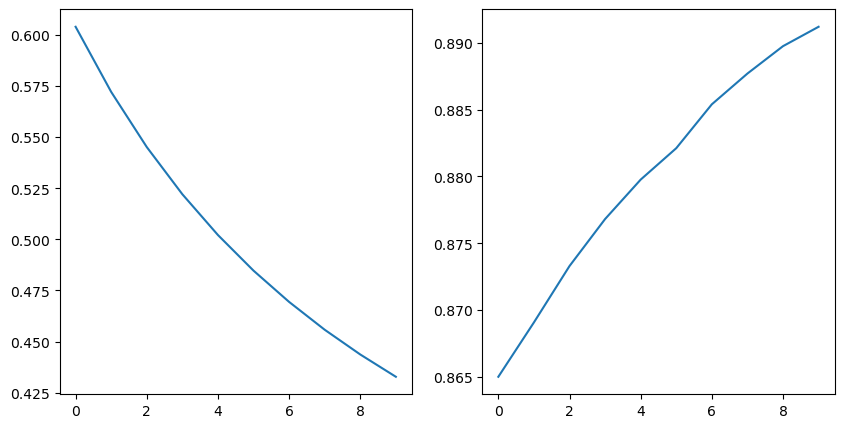

In [40]:
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.subplot(122)
plt.plot(hist.history['accuracy'])
plt.show()

loss가 어느정도 떨어지고 유지되는 구간이 있어야하는데 계속 떨어지고 있으므로 더 학습시킬 필요가 있어보임!

##### 모델 검증

In [41]:
# .evaluate
model.evaluate(test_x, test_y)

313/313 [==============================] - 0s 955us/step - loss: 0.4146 - accuracy: 0.8977


[0.41461968421936035, 0.8977000117301941]

##### 후처리

In [43]:
# .predict
pred = model.predict(test_x[:1])
pred.argmax()

1/1 [==============================] - 0s 17ms/step


7

In [47]:
test_y[0] # 이렇게 확인해도 되지만

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

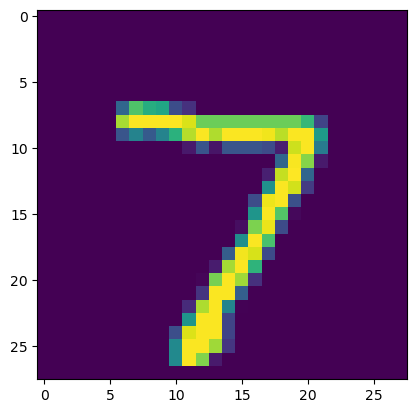

In [44]:
# 이미지로 확인하는 것이 더 좋음
sample_image = test_x[0].reshape((28, 28)) * 255 # 복구

plt.imshow(sample_image)
plt.show()